In [1]:
import time
import os

import cupy as cp
import numpy as np

import cudf
import dask
import dask_cudf
import dask.dataframe as dd
dask.config.set({"dataframe.backend": "cudf"})

import pandas as pd

from sklearn.ensemble import RandomForestClassifier as RF_cpu
from cuml.ensemble    import RandomForestClassifier as RF_gpu

import plotly.graph_objects as go
import dash

# Make Timer Class

In [2]:
class Timer:
    def __init__(self, name="cpu"):
        self.name = name
        
    def __enter__(self):
        self.start = time.perf_counter()
        
    def __exit__(self, type, value, trackback):
        self.end = time.perf_counter()
        self.execute_time = self.end - self.start
        print(f"{self.name} execute time : {self.execute_time:.4f} seconds")

In [3]:
data_path  = '/media/HDD2/Data/IBM_AML/AML'
LI_path = sorted([p for p in os.listdir(data_path) if p.startswith("LI")])
HI_path = sorted([p for p in os.listdir(data_path) if p.startswith("HI")])

In [4]:
HI_path

['HI-Large_Patterns.txt',
 'HI-Large_Trans.csv',
 'HI-Medium_Patterns.txt',
 'HI-Medium_Trans.csv',
 'HI-Small_Patterns.txt',
 'HI-Small_Trans.csv']

# Medium Transaction

In [5]:
with Timer(name="cpu") as cpu_time:
    train_data_cpu = pd.read_csv(os.path.join(data_path, HI_path[3]))
    train_data_cpu.to_parquet("./data/HI_Medium.parquet")

cpu execute time : 48.9582 seconds


In [12]:
with Timer(name="gpu") as gpu_time:
    train_data_gpu = cudf.read_csv(os.path.join(data_path, HI_path[3]))

gpu execute time : 3.2390 seconds


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /home/cvmi_jeyoung/anaconda3/envs/rapids/include/rmm/mr/device/cuda_memory_resource.hpp

In [5]:
with Timer(name="gpu") as gpu_time:
    train_data_gpu = dd.read_csv(os.path.join(data_path, HI_path[3]))

gpu execute time : 0.0538 seconds


In [6]:
train_data_gpu.compute()

KeyboardInterrupt: 

In [13]:
train_data_gpu.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

In [14]:
train_data_gpu = train_data_gpu.persist()

In [15]:
train_data_gpu.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

In [18]:
len(train_data_cpu["Payment Currency"].unique())

15

In [20]:
with Timer(name="cpu") as cpu_time:    
    filtered_cpu = train_data_cpu[train_data_cpu['Receiving Currency'] != train_data_cpu['Payment Currency']]
    
with Timer(name="gpu") as gpu_time:
    filtered_gpu = train_data_gpu[train_data_gpu['Receiving Currency'] != train_data_gpu['Payment Currency']]

cpu execute time : 1.5513 seconds
gpu execute time : 0.0010 seconds


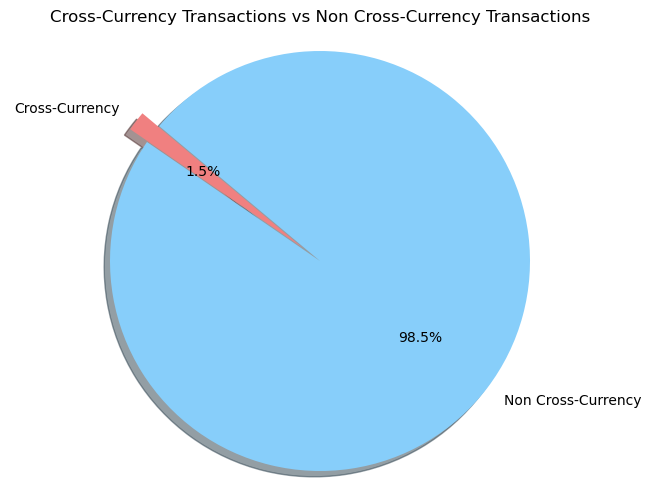

In [29]:
import matplotlib.pyplot as plt

cross_currency_count = len(filtered_cpu)
total_transactions = len(train_data_cpu)

non_cross_currency_count = total_transactions - cross_currency_count

labels = ['Cross-Currency', 'Non Cross-Currency']
sizes = [cross_currency_count, non_cross_currency_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Non Cross-Currency Transactions')
plt.axis('equal')
plt.show()

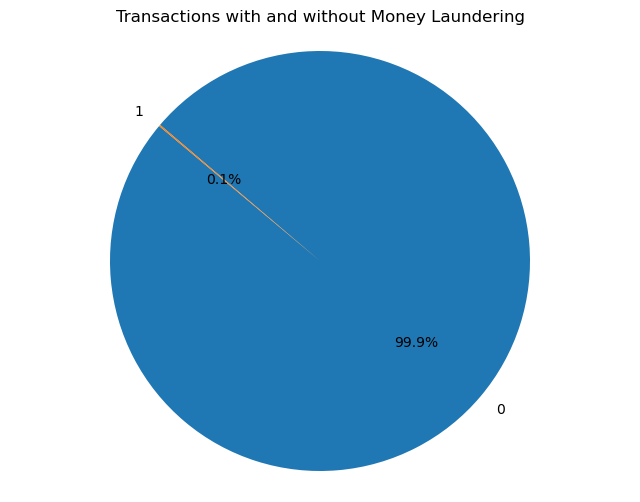

In [31]:

laundering_counts = train_data_cpu['Is Laundering'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(laundering_counts, labels=laundering_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Transactions with and without Money Laundering')
plt.axis('equal')
plt.show()

In [33]:
train_data_cpu['Is Laundering'].value_counts()

0    31863008
1       35230
Name: Is Laundering, dtype: int64

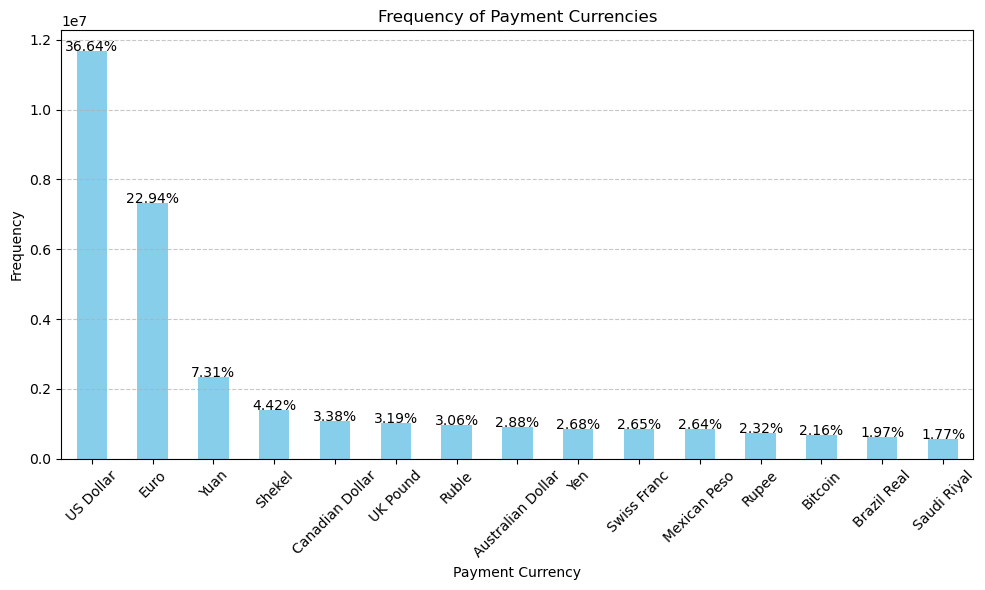

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

currency_counts = train_data_cpu['Payment Currency'].value_counts()
total_transactions = len(train_data_cpu)
currency_percentage = (currency_counts / total_transactions) * 100

plt.figure(figsize=(10, 6))
bars = currency_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Payment Currencies')
plt.xlabel('Payment Currency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(currency_counts):
    plt.text(i, v + 0.5, f'{currency_percentage.iloc[i]:.2f}%', ha='center')

plt.tight_layout()
plt.show()

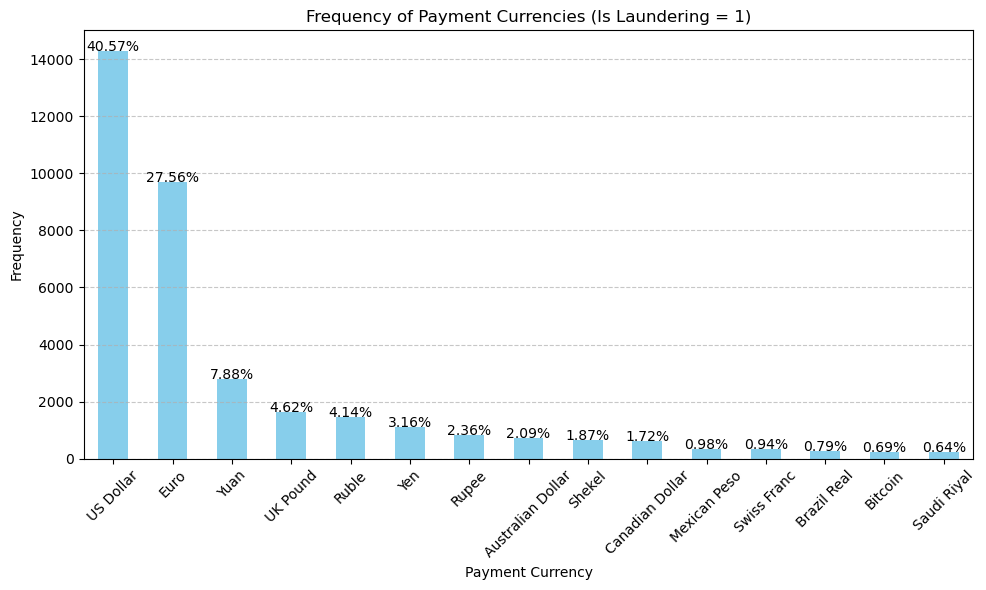

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

laundering_df =train_data_cpu[train_data_cpu['Is Laundering'] == 1]

currency_counts = laundering_df['Payment Currency'].value_counts()

total_transactions = len(laundering_df)
currency_percentage = (currency_counts / total_transactions) * 100

plt.figure(figsize=(10, 6))
bars = currency_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Payment Currencies (Is Laundering = 1)')
plt.xlabel('Payment Currency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(currency_counts):
    plt.text(i, v + 0.5, f'{currency_percentage.iloc[i]:.2f}%', ha='center')

plt.tight_layout()
plt.show()

/tmp/ipykernel_246313/779658623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_laundering_df['Timestamp'] = pd.to_datetime(money_laundering_df['Timestamp'])
/tmp/ipykernel_246313/779658623.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_laundering_df['Day'] = money_laundering_df['Timestamp'].dt.day


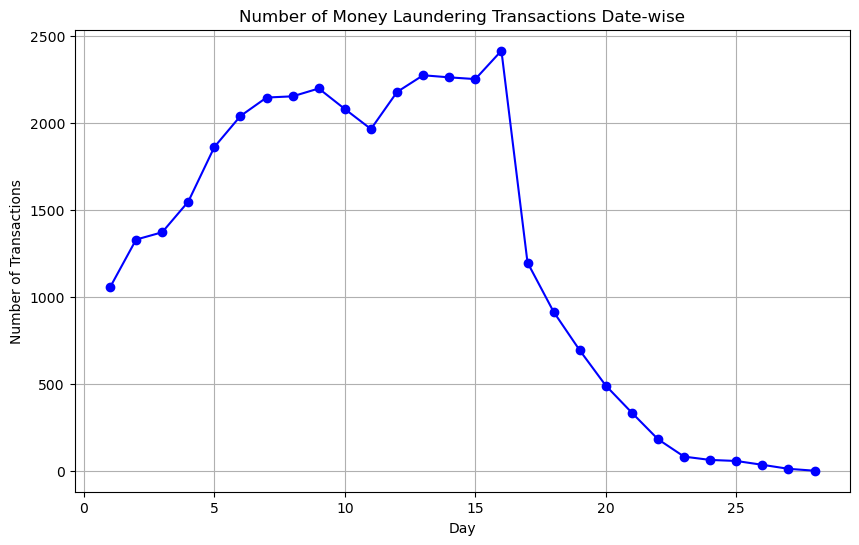

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing transaction data

# Step 1: Filter money laundering data
money_laundering_df = train_data_cpu[train_data_cpu['Is Laundering'] == 1]

# Step 2: Convert Timestamp column to datetime
money_laundering_df['Timestamp'] = pd.to_datetime(money_laundering_df['Timestamp'])

# Step 3: Extract year from Timestamp
money_laundering_df['Day'] = money_laundering_df['Timestamp'].dt.day

# Step 4: Count number of transactions for each year
transactions_by_year = money_laundering_df.groupby('Day').size()

# Step 5: Visualize the number of transactions year-wise
transactions_by_year.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

# CPU Stopped!!

In [ ]:
not_equal1 = train_data_cpu.loc[~(train_data_cpu['Amount Received'] == train_data_cpu['Amount Paid'])]
not_equal2 = train_data_cpu.loc[~(train_data_cpu['Receiving Currency'] == train_data_cpu['Payment Currency'])]

# Assuming you have already loaded your DataFrame df

# Count the occurrences of each bank in the To Bank column
bank_counts = train_data_cpu['From Bank'].value_counts()

plt.figure(figsize=(10, 6))
# Plot the bar plot
bars = bank_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Bank')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per Bank')

# Show the plot
plt.show()

In [ ]:
# Convert Timestamp to datetime
train_data_cpu['Timestamp'] = pd.to_datetime(train_data_cpu['Timestamp'])

# Extract hour of the day
train_data_cpu['Hour'] = train_data_cpu['Timestamp'].dt.hour

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(train_data_cpu['Hour'], train_data_cpu['Is Laundering'], c=train_data_cpu['Is Laundering'], cmap='coolwarm', alpha=0.7)

# Customizing plot
plt.title('Hour of Day vs Is Laundering')
plt.xlabel('Hour of Day')
plt.ylabel('Is Laundering')
plt.yticks([0, 1], ['No', 'Yes'])  # Customizing y-axis ticks
plt.grid(True)
plt.tight_layout()

# Show red dots for laundering transactions
plt.scatter(hf[hf['Is Laundering'] == 1]['Hour'], hf[hf['Is Laundering'] == 1]['Is Laundering'], c='red')

# Show plot
plt.show()